<a href="https://colab.research.google.com/github/ykato27/Reinforcement-Learning/blob/main/2_3_Policygradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

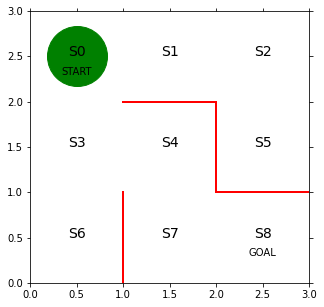

In [2]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [3]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [4]:
# 方策パラメータthetaを行動方策piにソフトマックス関数で変換する手法の定義


def softmax_convert_into_pi_from_theta(theta):
    '''ソフトマックス関数で割合を計算する'''

    beta = 1.0
    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # thetaをexp(theta)へと変換

    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # simpleに割合の計算の場合

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # softmaxで計算の場合

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

In [5]:
# 初期の方策pi_0を求める
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [6]:
# 行動aと1step移動後の状態sを求める関数を定義


def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]の確率に従って、directionが選択される
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return [action, s_next]

In [7]:
# 迷路を解く関数の定義、状態と行動の履歴を出力


def goal_maze_ret_s_a(pi):
    s = 0  # スタート地点
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 現在の状態（つまり一番最後なのでindex=-1）の行動を代入

        s_a_history.append([next_s, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        if next_s == 8:  # ゴール地点なら終了
            break
        else:
            s = next_s

    return s_a_history

In [8]:
# 初期の方策で迷路を解く
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

[[0, 2], [3, 2], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 0], [4, 3], [3, 2], [6, 0], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 1], [8, nan]]
迷路を解くのにかかったステップ数は24です


In [9]:
# thetaの更新関数を定義します


def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習率
    T = len(s_a_history) - 1  # ゴールまでの総ステップ数

    [m, n] = theta.shape  # thetaの行列サイズを取得
    delta_theta = theta.copy()  # Δthetaの元を作成、ポインタ参照なので、delta_theta = thetaはダメ

    # delta_thetaを要素ごとに求めます
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴から状態iのものを取り出すリスト内包表記です

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 状態iで行動jをしたものを取り出す

                N_i = len(SA_i)  # 状態iで行動した総回数
                N_ij = len(SA_ij)  # 状態iで行動jをとった回数
                
                # 初版では符号の正負に間違いがありました（修正日：180703）
                #delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

In [10]:
# 方策の更新
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.49687504 0.50312496 0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33147637 0.33147637 0.33704727 0.        ]
 [0.         0.         0.50104167 0.49895833]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [11]:
# 方策勾配法で迷路を解く

# 初版で、def update_thetaに間違いがあった関係で、終了条件を変更します（修正日：180703）
#stop_epsilon = 10**-8  # 10^-8よりも方策に変化が少なくなったら学習終了とする
stop_epsilon = 10**-4  # 10^-4よりも方策に変化が少なくなったら学習終了とする


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # is_continueがFalseになるまで繰り返す
    s_a_history = goal_maze_ret_s_a(pi)  # 方策πで迷路内を探索した履歴を求める
    new_theta = update_theta(theta, pi, s_a_history)  # パラメータΘを更新
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 方策πの更新

    print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

ストリーミング出力は最後の 5000 行に切り捨てられました。
0.0029384163579905982
迷路を解くのにかかったステップ数は6です
0.00375022729214311
迷路を解くのにかかったステップ数は6です
0.0008857385943786406
迷路を解くのにかかったステップ数は4です
0.0008817804672287197
迷路を解くのにかかったステップ数は4です
0.0008778490816732168
迷路を解くのにかかったステップ数は4です
0.0008739441944832851
迷路を解くのにかかったステップ数は4です
0.0029048006472590718
迷路を解くのにかかったステップ数は6です
0.0008764291449162159
迷路を解くのにかかったステップ数は4です
0.0008725443318059675
迷路を解くのにかかったステップ数は4です
0.000868685506134708
迷路を解くのにかかったステップ数は4です
0.0008648524341889723
迷路を解くのにかかったステップ数は4です
0.0037483540685849664
迷路を解くのにかかったステップ数は6です
0.0008771279226178277
迷路を解くのにかかったステップ数は4です
0.0008732143980016566
迷路を解くのにかかったステップ数は4です
0.0008693273267455122
迷路を解くのにかかったステップ数は4です
0.002730447098947167
迷路を解くのにかかったステップ数は6です
0.0008721138559481326
迷路を解くのにかかったステップ数は4です
0.0008682450329733152
迷路を解くのにかかったステップ数は4です
0.0008644021644093475
迷路を解くのにかかったステップ数は4です
0.0008605850157689075
迷路を解くのにかかったステップ数は4です
0.0008567933552359221
迷路を解くのにかかったステップ数は4です
0.0008530269536305111
迷路を解くのにかかったステップ数は4です
0.0008492855843698945
迷路を解

In [12]:
# 最終的な方策を確認
np.set_printoptions(precision=3, suppress=True)  # 有効桁数3、指数表示しないという設定
print(pi)

[[0.    0.015 0.985 0.   ]
 [0.    0.215 0.    0.785]
 [0.    0.    0.437 0.563]
 [0.011 0.979 0.01  0.   ]
 [0.    0.    0.988 0.012]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.017 0.983 0.    0.   ]]


In [13]:
# エージェントの移動の様子を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())